# Initialization

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [11]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 10
ROUNDS = 10
OTHER_DATE = '2021-11-11'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

# Get IQ data

In [12]:
SHOTS = int(1e4)
NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]
# NOISE_LIST = None
P_AMBIG = 0.3

IQ_data= simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)
IQ_data_extreme = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_list=NOISE_LIST)

100%|██████████| 9998/9998 [00:06<00:00, 1599.01it/s]


# Pickle for other applications

In [13]:
import pickle

with open('IQ_data.pkl', 'wb') as f:
    pickle.dump(IQ_data, f)

with open('IQ_data_extreme.pkl', 'wb') as f:
    pickle.dump(IQ_data_extreme, f)

with open('qubit_mapping.pkl', 'wb') as f:
    pickle.dump(simulator.qubit_mapping, f)

with open('stim_circ.pkl', 'wb') as f:
    pickle.dump(simulator.stim_circ, f)

# Simulator

# Decode IQ data

In [14]:
import pymatching
import stim

model = simulator.stim_circ.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

# Using cpp kde

In [15]:
import cpp_soft_info

_DETAILED = True

matching = pymatching.Matching.from_detector_error_model(model)
result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                            p_offset = 1, p_multiplicator = 1, _ntnn_edges = not _RESETS)

matching = pymatching.Matching.from_detector_error_model(model)
result_extreme = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = not _RESETS)

print("num_errors:", result.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors EXTREME:", result_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

ValueError: Count string must be one bit longer than each check string.

In [9]:
p_meas = -1
# p_meas = 30e-2 

matching = pymatching.Matching.from_detector_error_model(model)
result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data[:],
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

matching = pymatching.Matching.from_detector_error_model(model)
result_informed_extreme = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data_extreme[:],
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                             p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

print("num_errors:", result_informed.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors EXTREME:", result_informed_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)
         
# takes 1s

num_errors: 445 out of 10000 shots for _RESETS = False
num_errors EXTREME: 1381 out of 10000 shots for _RESETS = False


In [10]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=_DETAILED)

matching = pymatching.Matching.from_detector_error_model(model)
result_flat_extreme = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data_extreme,
                                                         ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                                            simulator.processed_scaler_dict, _detailed=_DETAILED)

print("num_errors:", result_flat.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors EXTREME:", result_flat_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

num_errors: 474 out of 10000 shots for _RESETS = False
num_errors EXTREME: 2103 out of 10000 shots for _RESETS = False


# Plot the results

In [11]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)
print("\nIQ EXTREME:", result_extreme.indices, "\nFlat EXTREME:", result_flat_extreme.indices, "\nInformed EXTREME", result_informed_extreme.indices)


IQ: [5564, 5586, 5836, 5935, 5980, 5987, 5990, 6033, 6178, 6203, 6205, 6231, 6280, 6316, 6347, 6395, 6441, 6468, 6481, 6535, 6578, 6596, 6848, 6851, 6874, 6884, 6904, 6949, 6978, 6990, 7087, 7089, 7278, 7385, 7395, 7407, 7436, 7496, 7507, 7515, 7549, 7639, 7731, 7732, 7733, 7735, 7736, 7737, 7739, 7740, 7741, 7785, 7862, 7952, 7953, 7954, 7955, 7956, 7957, 7958, 7959, 7960, 7977, 7978, 7979, 7980, 7981, 7982, 7983, 8001, 8028, 8073, 8514, 8604, 8614, 8615, 8616, 8617, 8619, 8620, 8621, 8622, 8624, 8638, 8688, 8693, 8699, 8913, 8914, 8915, 8916, 8918, 8920, 8921, 8922, 8924, 8935, 8996, 9007, 9011, 9029, 9032, 9078, 9088, 9111, 9112, 9113, 9114, 9115, 9116, 9133, 9139, 9140, 9141, 9142, 9143, 9144, 9145, 9146, 9147, 9155, 9162, 9163, 9164, 9166, 9167, 9168, 9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9194, 9195, 9196, 9197, 9198, 9199, 9200, 9201, 9202, 9204, 9205, 9206, 9207, 9209, 9210, 9211, 9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223

-----IQ True decoding -----


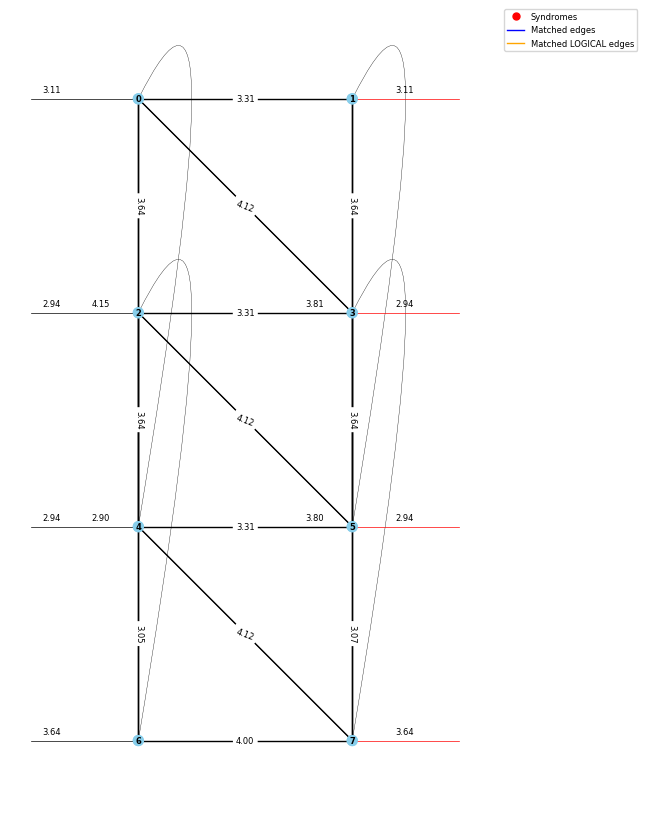

-----flat True decoding-----


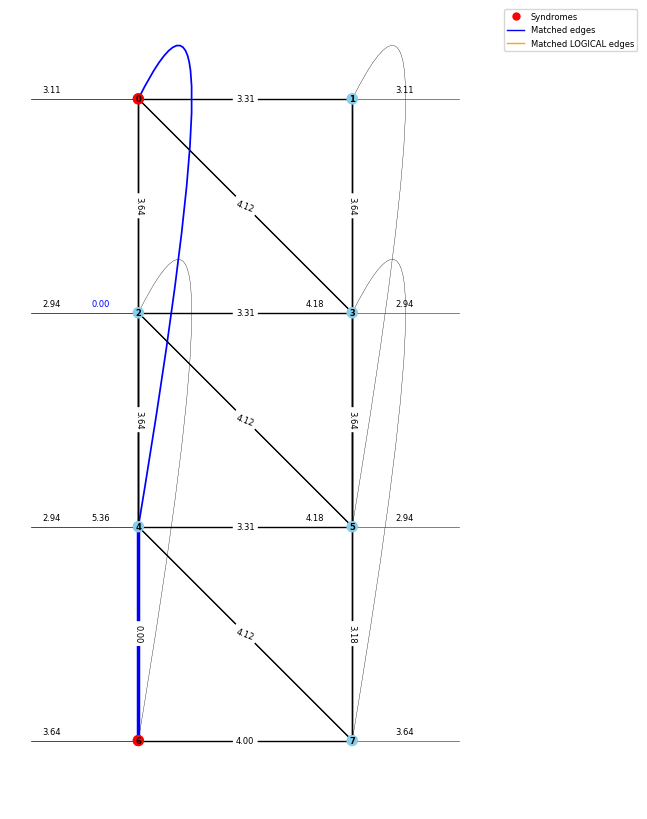

-----INFORMED True decoding-----


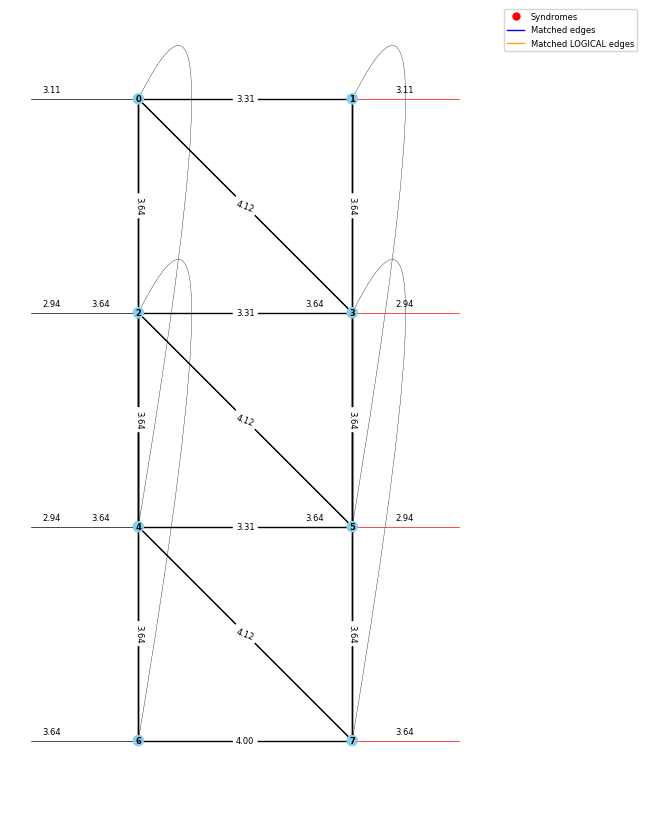

In [12]:
from soft_info import draw_matching_graph


index = 100

fig_size = (4, 13)
fig_size = (8, 8)
scale_factor = 0.5

to_be_result = result
details = to_be_result.error_details[index]
print(f"-----IQ {bool(not (index in to_be_result.indices))} decoding -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_extreme
details = to_be_result.error_details[index]
print(f"-----flat {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print(f"-----INFORMED {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [13]:
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print("indices that are in informed but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print("indices that are in IQ but not in informed with len:", len(iq_not_in_informed))
print(iq_not_in_informed)

print()

iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print("indices that are in IQ but not in flat with len:", len(iq_not_in_flat))
print(iq_not_in_flat)
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print("indices that are in flat but not in IQ with len:", len(flat_not_in_iq))
print(flat_not_in_iq)

indices that are in informed but not in IQ with len: 57
[25, 435, 5542, 5613, 5850, 6151, 6402, 6538, 6570, 6585, 6838, 6856, 6956, 7097, 7100, 7401, 7413, 7498, 7730, 7734, 7738, 7818, 8917, 8923, 8947, 8989, 9006, 9193, 9208, 9308, 9387, 9388, 9405, 9546, 9548, 9555, 9640, 9686, 9732, 9823, 9824, 9825, 9826, 9866, 9867, 9873, 9894, 9895, 9910, 9940, 9947, 9948, 9949, 9979, 9982, 9985, 9999]
indices that are in IQ but not in informed with len: 33
[5564, 5987, 6874, 6978, 7395, 7436, 7515, 7549, 7639, 7785, 8001, 8028, 8073, 8693, 9078, 9246, 9447, 9651, 9652, 9656, 9681, 9682, 9729, 9852, 9868, 9938, 9939, 9951, 9952, 9961, 9967, 9969, 9991]

indices that are in IQ but not in flat with len: 89
[6205, 6848, 6874, 6978, 7436, 7639, 8604, 9078, 9088, 9115, 9246, 9273, 9274, 9275, 9276, 9277, 9279, 9280, 9281, 9282, 9284, 9296, 9329, 9330, 9331, 9333, 9334, 9335, 9336, 9337, 9339, 9340, 9386, 9389, 9390, 9391, 9392, 9393, 9447, 9455, 9456, 9457, 9458, 9545, 9549, 9554, 9556, 9557, 9558, 9

# Analyse specific shots

{'010 01 00 00': 1}


100%|██████████| 25/25 [00:00<00:00, 609637.21it/s]

mean time edge weight: 3.0153505423804745

[(2, 6), (5, 4)]
-----IQ-----


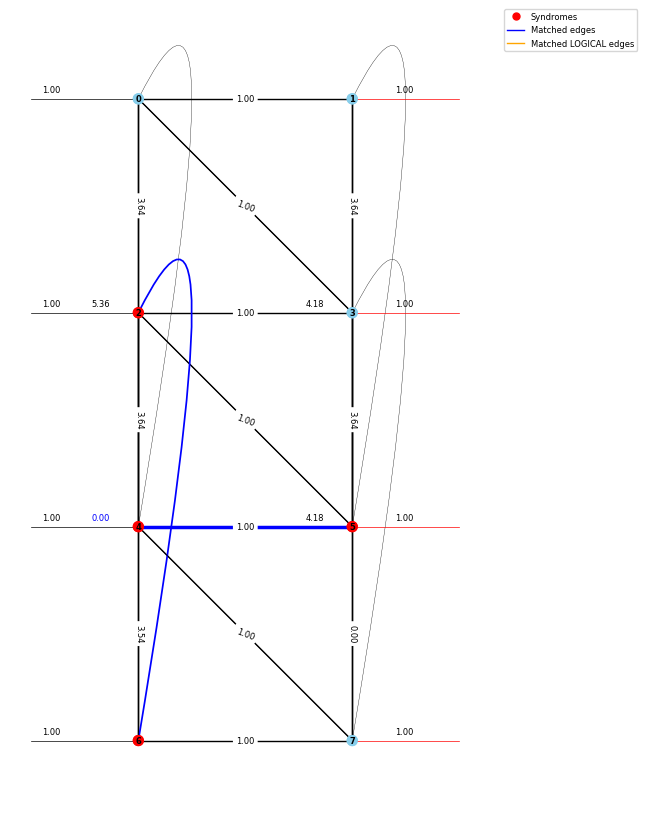

In [14]:
from tqdm import tqdm

index = 83
IQ_data_new = IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = True)

print(cpp_soft_info.get_counts(IQ_data_new, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print()
print(details.matched_edges)

print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)